# Decoding Force Intended to be Exerted to Lift an Object of Unknown Weight from EEG Data

### Data Set Description:
!2 Participants engaged in a grasp-lift movement task where they were asked to repeat a series of trials that consisted of reaching for the an object, lifting it up, holding it in place, and then putting it back down. The weight of the object was unknown to the participant, and data was recorded using an EEG cap on the participant's head as well as force sensors on the object being lifted.

### Project Objective
It is a well known fact when lifting an object of unknown weight, the previous trial heavily influences how much force you will exert on the new object since that is your only point of reference. Using EEG data from the time at which the subject starts to reach for the object to when they start to pick up it, we attempt to decode whether they intend to lift a heavy or light object

### Summary of Results

We implemented a binary logistic regression to classify eeg data as either intending to lift a heavy or light object. 

<b> Time x Voltage Model </b>
This method of analysis had too many features (time points) compared to samples (channels) which caused the model to overfit on training data. We used PCA to reduce the dimesnions, but the accuracy was still below chance.

<b> Spectral Model </b>
We converted our time series data into time-frequency domain and averaged across the known frequency ranges of alpha, beta, theta, and delta waves. This method helped reduce the number of features of our model, yielding an accuracy of 81%

## Libraries

In [5]:
from __future__ import division
import numpy as np
import scipy.io as scipy
import matplotlib.pyplot as plt
!pip install mne
import mne
from numpy import *
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import sklearn

## Helper Functions

### Reading .mat Files

In [6]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

### MNE Preprocessing

In [7]:
def preprocess_trial_data( data, info):
    # Create raw array object
    mne_rarray = mne.io.RawArray( data, info)
    
    # Common-average referencing of data
    rrf_rarray = mne_rarray.copy().set_eeg_reference( ref_channels='average')
    
    # Application of FIR bandpass filter
    #fil_length = str(((441-1)/(2*500))*1000) + "ms"
    flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
   
    #################################################################################
    # TODO: Determine if we want to return an ica object instead of the filtered data
    #     ica = mne.preprocessing.ICA( n_components = 32)
    #     ica.fit( flt_rarray)
    #     return ica
    #################################################################################
    
    return flt_rarray

## EEG Setup Information

In [8]:
# Electrode names from data decription file
#'Fp1','Fp2','F7','F3','Fz','F4','F8',,'P7','P3','Pz','P4','P8','PO9','O1','Oz','O2','PO10'
ch_names = ['FC5',
            'FC1','FC2','FC6','T7','C3','Cz','C4','T8',
            'TP9','CP5','CP1','CP2','CP6','TP10']

# Directory of channel locations
'''"Fp1": [-2.7, 8.6, 3.6],"Fp2": [2.7, 8.6, 3.6],
          "F7": [-6.7, 5.2, 3.6],"F3": [-4.7, 6.2, 8],
          "Fz": [0, 6.7, 9.5],"F4": [4.7, 6.2, 8],
          "F8": [6.7, 5.2, 3.6],"P7": [-6.7, -5.2, 3.6],
          "P3": [-4.7, -6.2, 8],
          "Pz": [0, -6.7, 9.5],"P4": [4.7, -6.2, 8],
          "P8": [6.7, -5.2, 3.6],"PO9": [-4.7, -6.7, 0],
          "O1": [-2.7, -8.6, 3.6],"Oz": [0, -9, 3.6],
          "O2": [2.7, -8.6, 3.6],"PO10": [4.7, -6.7, 0],
          '''
ch_pos = {
          "FC5": [-5.5, 3.2, 6.6],
          "FC1": [-3, 3.3, 11],"FC2": [3, 3.3, 11],
          "FC6": [5.5, 3.2, 6.6],"T7": [-7.8, 0, 3.6],
          "C3": [-6.1, 0, 9.7],"Cz": [0, 0, 12],
          "C4": [6.1, 0, 9.7],"T8": [7.8, 0, 3.6],
          "TP9": [-7.3, -2.5, 0],"CP5": [-7.2, -2.7, 6.6],
          "CP1": [-3, -3.2, 11],"CP2": [3, -3.2, 11],
          "CP6": [7.2, -2.7, 6.6], "TP10": [7.3, -2.5, 0]}


# Channel montage
chan_locs = mne.channels.make_dig_montage(ch_pos)

# Sampling frequency in Hz
s_freq = 500

# Must specify channel type to enable filtering
info = mne.create_info( ch_names, s_freq, ch_types = "eeg")
info = info.set_montage(montage = chan_locs , verbose = None)
type(info)

<ipython-input-8-5d32e5872e5b>:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = info.set_montage(montage = chan_locs , verbose = None)


mne.io.meas_info.Info

## Loading Data For A Single Participant

In [90]:
#########################################################
# TODO: This section could be better off as a function(?)
#########################################################

# Extract relevant data from Participant 1
#p1 = loadmat('P1/WS_P1_S9.mat')

# Load AllLifts for P1
p1_all = loadmat('P1/P1_AllLifts.mat')
print( "All Lifts loaded")

# series with weight changing only
weight_series = [1, 4, 7, 8, 9]
trialStartIdx = [ 1, 97, 193, 227, 261]

i = 0

eeg_data_raw = []
weight_class = []

for s in weight_series:
    # load data for series
    series_filename = 'P1/WS_P1_S{series}.mat'.format(series = s)
    p_series = loadmat(series_filename)
    print("Series data loaded")

    tStart = trialStartIdx[i]
    # Increment i for next start index
    i += 1
    # trial counter
    trial = 0

    for t in range(tStart, tStart + 33):
        # retrieve time from LED flash to picking up the object
        tLEDon = 2.0
        tStartLoadPhase = np.array(p1_all['P']['AllLifts'])[t, 17]

        # slice EEG window to desired time interval (currently startLoad - 1:startLoad)
        #idxStart = int((tStartLoadPhase - 1) // 0.002)
        #highest accuracy idxEnd = +500, idxStart = -1500
        
        idxEnd = int(tStartLoadPhase // 0.002) + 500
        idxStart = idxEnd - 500
        eeg_trial = np.array(p_series['ws']['win'][trial]['eeg'])[idxStart:idxEnd, 7:22].T
        #print(eeg_trial.shape)
        
        # slice force data to the same time interval
        #loadforce = np.array(p_series['ws']['win'][trial]['kin'])[idxLEDon:idxStartLoad, 38]
        
        # Get previous weight class (intended weight)
        prev_weight = np.array(p1_all['P']['AllLifts'])[t, 5]
        
        if prev_weight == 2:
            continue
        else:
            eeg_data_raw.append(eeg_trial)
            weight_class.append(prev_weight)
            
           
        
        # Increment trial number for accessing EEG data
        trial += 1

eeg_data_raw = np.asarray(eeg_data_raw)
weight_class = np.asarray(weight_class)

All Lifts loaded
Series data loaded
Series data loaded
Series data loaded
Series data loaded
Series data loaded


In [91]:
print(eeg_data_raw.shape)

(110, 15, 500)


## Preprocessing Pipeline For All Relevant Trials

In [92]:
trials = np.arange( 0, len( eeg_data_raw))

flt_rarray_data = []
flt_data = []

for trial in trials:
    trial_data = eeg_data_raw[ trial]
    flt_rarray_data.append(preprocess_trial_data( trial_data, info))
    flt_data.append( preprocess_trial_data( trial_data, info).get_data())
    
flt_data = np.asarray( flt_data)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters


<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuat

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)



Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Appl

<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)
<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


Creating RawArray with float64 data, n_channels=15, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



<ipython-input-7-790e7c10c02a>:10: RuntimeWarning: filter_length (16501) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = .1, h_freq = 30)


In [93]:

flt_data.shape
flt_data_reshaped = flt_data.reshape((110,15*500 ))
flt_data_reshaped.shape

(110, 7500)

In [94]:
flt_data.shape

(110, 15, 500)

## Visualized Filtered Data

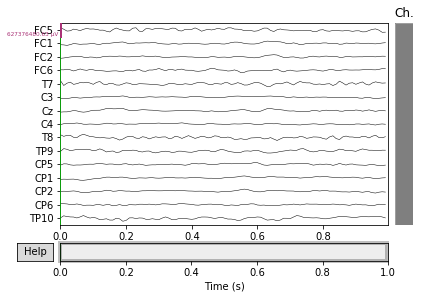

Effective window size : 1.000 (s)


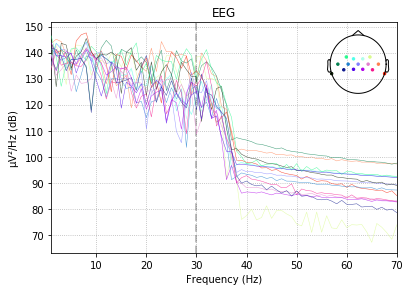

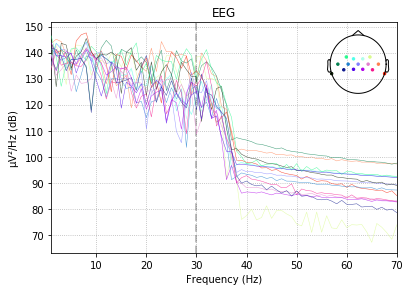

In [95]:
flt_rarray_data[ 0].plot( n_channels = 15, scalings = "auto")
flt_rarray_data[ 0].plot_psd( fmin = 0.1, fmax = 70)

In [96]:
psd, freqs = mne.time_frequency.psd_array_welch(flt_data, sfreq= 500,fmin = 1, fmax = 30)

Effective window size : 0.512 (s)


In [97]:
freqs.shape

(15,)

In [98]:
print(freqs)

[ 1.953125  3.90625   5.859375  7.8125    9.765625 11.71875  13.671875
 15.625    17.578125 19.53125  21.484375 23.4375   25.390625 27.34375
 29.296875]


In [99]:
psd.shape

(110, 15, 15)

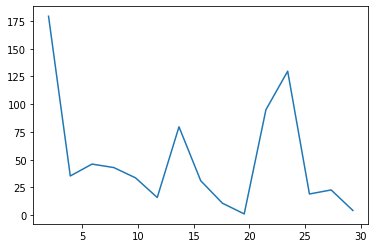

In [100]:
plt.plot(freqs, psd[0,4,:])

In [101]:
all_trials_avg = []
for i in range(len(psd)):
    trial_psd = psd[i,:,:]
    delta_avg = np.mean(trial_psd[:,freqs <= 2], axis = 1)
    theta_avg = np.mean(trial_psd[:,(freqs <= 8) & (freqs >2)], axis = 1)
    alpha_avg = np.mean(trial_psd[:,(freqs <= 12) & (freqs >8)], axis = 1)
    beta_avg = np.mean(trial_psd[:,(freqs <= 30) & (freqs >12)], axis = 1)
    
    trial_avg = np.hstack((delta_avg, theta_avg, alpha_avg, beta_avg))
    all_trials_avg.append(trial_avg)
    
all_trials_avg = np.asarray(all_trials_avg)
    
    

In [102]:
all_trials_avg.shape

(110, 60)

## Time Frequency Model

In [103]:
X_train_psd, X_test_psd, y_train_psd, y_test_psd = sklearn.model_selection.train_test_split(all_trials_avg, weight_class, test_size=0.1, random_state=42)



In [104]:
X_train_psd.shape

(99, 60)

In [105]:
log_reg_psd = LogisticRegression(penalty = 'none', max_iter = 1000)

#Then fit it to data
log_reg_psd.fit(X_train_psd, y_train_psd)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [106]:
y_pred_psd = log_reg_psd.predict(X_test_psd)
print(y_pred_psd)

[4. 1. 4. 4. 1. 1. 4. 1. 1. 4. 4.]


In [107]:
print(y_test_psd)

[4. 4. 4. 4. 1. 1. 1. 1. 1. 4. 4.]


In [108]:
print(sklearn.metrics.r2_score(y_test_psd, y_pred_psd))

0.2666666666666666


### Accuracy: 81%

In [109]:
score_psd = log_reg_psd.score(X_test_psd, y_test_psd)
print(score_psd)

0.8181818181818182


In [110]:
accuracies = cross_val_score(LogisticRegression(penalty="none",max_iter = 500), all_trials_avg, weight_class, cv=8)
print(accuracies)

[0.42857143 0.57142857 0.57142857 0.35714286 0.42857143 0.92857143
 0.53846154 0.69230769]


## Time By Voltge Model below

In [111]:
# 3 seconds before they start to lift, -1 second from reach to lift, 1 second after lift
#narrow down electrodes (13 electrodes)
#1-2 delta, 3-8 theta, 9-12 alpha, 13-30 beta
#for each electrode in each trial, bin by 4 frequencies (165x(13*4)
# take average power for theta, alpha, and beta across the time window

In [112]:
y = weight_class
print(y)
weight_class.shape


[1. 1. 1. 1. 4. 1. 1. 1. 4. 4. 4. 4. 4. 4. 1. 1. 1. 4. 4. 4. 4. 1. 4. 4.
 1. 4. 4. 4. 4. 1. 1. 4. 1. 1. 1. 1. 4. 1. 1. 1. 1. 4. 4. 4. 1. 1. 4. 4.
 4. 4. 1. 1. 1. 1. 4. 4. 4. 1. 4. 4. 4. 1. 4. 1. 1. 1. 1. 1. 1. 1. 4. 1.
 1. 1. 4. 4. 4. 4. 4. 4. 1. 1. 1. 4. 4. 4. 4. 1. 4. 4. 1. 4. 4. 4. 4. 1.
 1. 4. 1. 1. 1. 1. 4. 1. 1. 1. 1. 4. 4. 4.]


(110,)

In [113]:
X = flt_data_reshaped
#X = flt_data
X.shape

(110, 7500)

In [114]:
y.shape

(110,)

In [115]:
 X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=42)

In [116]:
pca_x_train = PCA(n_components = 0.9)
pca_x_train.fit(X_train)
X_train_reduced = pca_x_train.transform(X_train)

In [117]:
X_train_reduced.shape

(99, 24)

In [118]:
#pca_x_test = PCA(n_components = 0.9)
#pca_x_train.fit(X_test)
X_test_reduced = pca_x_train.transform(X_test)
X_test_reduced.shape

(11, 24)

In [119]:
y_train.shape

(99,)

In [120]:
# First define the model
log_reg = LogisticRegression(penalty="none", max_iter = 500)

#Then fit it to data
log_reg.fit(X_train_reduced, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [121]:
y_pred = log_reg.predict(X_test_reduced)
print(y_pred)


[1. 1. 1. 4. 1. 1. 4. 1. 4. 1. 1.]


In [122]:
print(y_test)

[4. 4. 4. 4. 1. 1. 1. 1. 1. 4. 4.]


In [123]:
print(sklearn.metrics.r2_score(y_test, y_pred))

-1.5666666666666669


### Accuracy: 36%

In [124]:
score = log_reg.score(X_test_reduced, y_test)
print(score)

0.36363636363636365


In [125]:
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8)
print(accuracies)

[0.5        0.5        0.57142857 0.64285714 0.35714286 0.42857143
 0.61538462 0.07692308]


### SVM Classification

In [126]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_reduced)
X_train = scaler.transform(X_train_reduced)
X_test  = scaler.transform(X_test_reduced)
clf = SVC()
y_train = y_train.reshape((len(y_train),1))
y_test = y_test.reshape((len(y_test),1))
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = np.mean(y_predict == y_test)
print(acc)

0.48760330578512395


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
